### Benchmarking on Models

Now that we know how to use Yuzu, let's take a look at how to use it using a few built-in models. These models are mostly based on published architectures but have randomly initialized weights. This is for two reasons: first, it's somewhat difficult to get trained models in a PyTorch readable format, and second, randomized weights will highlight issues in the ISM procedure faster than trained (i.e., correlated) weights. 

In [1]:
%pylab inline
import time
import seaborn; seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


Let's start off by loading the two functions we need from Yuzu as well as the Naive ISM procedure and the six built-in models.

In [2]:
from yuzu import yuzu_ism, precompute
from yuzu.naive_ism import naive_ism
from yuzu.models import OneLayer, ToyNet, DeepSEA, Basset, FactorizedBasset, BPNet

Now, let's scan through each of the models and compare Yuzu times and ISM scores to the naive ISM baseline. This benchmark will not be as comprehensive as the one in the manuscript because it'll be performed on a single sequence, a single time instead of operating on several iterations, and without minimizing warm-up costs associated with using a GPU.

In [3]:
seq_len, n_choices = 1000, 4

idxs = numpy.random.RandomState(0).randn(n_choices, seq_len).argmax(axis=0)
X = numpy.zeros((1, n_choices, seq_len), dtype='float32')
X[0, idxs, numpy.arange(seq_len)] = 1

yuzu_results, yuzu_times = [], []
naive_results, naive_times = [], []

for model in OneLayer, ToyNet, DeepSEA, Basset, FactorizedBasset, BPNet:
    model = model(seq_len=seq_len, n_inputs=n_choices)
    precomputation = precompute(model, seq_len, n_choices, device='cuda')
    
    tic = time.time()
    yuzu_result = yuzu_ism(model, X, precomputation, device='cuda')
    yuzu_time = time.time() - tic
    
    yuzu_results.append(yuzu_result)
    yuzu_times.append(yuzu_time)
    
    tic = time.time()
    naive_result = naive_ism(model, X, device='cuda')
    naive_time = time.time() - tic

    naive_results.append(naive_result)
    naive_times.append(naive_time)

/users/jmschr/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Now we can plot the time and ISM scores for each of the models.

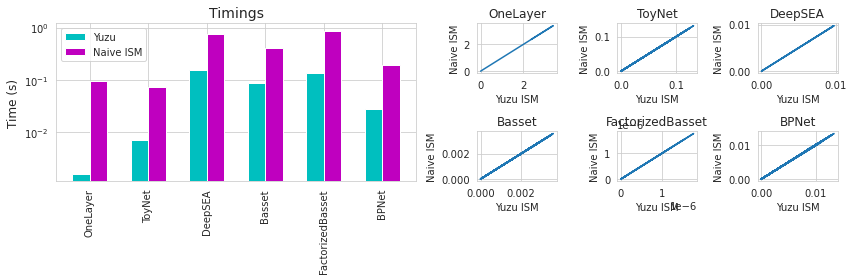

In [4]:
from matplotlib.gridspec import GridSpec

model_names = 'OneLayer', 'ToyNet', 'DeepSEA', 'Basset', 'FactorizedBasset', 'BPNet'

gs = GridSpec(nrows=2, ncols=6)

plt.figure(figsize=(12, 4))
plt.subplot(gs[:, :3])
plt.title("Timings", fontsize=14)
plt.bar(numpy.arange(0, 6)-0.15, yuzu_times, color='c', width=0.3, label="Yuzu")
plt.bar(numpy.arange(0, 6)+0.15, naive_times, color='m', width=0.3, label="Naive ISM")
plt.xticks(range(6), model_names, rotation=90)
plt.ylabel("Time (s)", fontsize=12)
plt.yscale('log')
plt.legend(loc=2)

for i, model_name in enumerate(model_names):
    plt.subplot(gs[i // 3, 3 + (i % 3)])
    plt.title(model_name)
    plt.plot(yuzu_results[i][0].flatten(), naive_results[i][0].flatten())
    plt.xlabel("Yuzu ISM", fontsize=10)
    plt.ylabel("Naive ISM", fontsize=10)
    
plt.tight_layout()
plt.show()

Although the left panel makes the cardinal sin of being a bar plot on log space, we'll be lazy and use it because the speeds are on different orders of magnitude. We can see that the Yuzu is much faster for all of the models, up to an order of magnitude even in this limited evaluation.

We can also see that the ISM scores are very accurate. We have the ISM scores produced by Yuzu on the x-axis and the ISM scores produced by naive ISM on the y-axis. To demonstrate that these are almost identical we can calculate the correlation for each model:

In [5]:
[numpy.corrcoef(x[0].flatten(), y[0].flatten())[0, 1] for x, y in zip(yuzu_results, naive_results)]

[0.9999999956482851,
 0.9999996279640911,
 0.999999966892026,
 0.9999994102622134,
 0.999991260077285,
 0.9999956745152919]

Well... Yuzu is an approximate method after all.